<a href="https://colab.research.google.com/github/Samarth-991/Medical-Data-Handling/blob/main/COPD_Classification_multiple_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d vbookshelf/respiratory-sound-database
# ! sudo unzip /content/respiratory-sound-database.zip
# ! rm -rf /content/respiratory-sound-database.zip
# ! rm -rf /content/respiratory_sound_database
# !pip install soundfile

In [ ]:
import matplotlib.pyplot as plt
import librosa
import soundfile as sf 
import librosa.display
import numpy as np
import pandas as pd 
import os 
import math
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import gc 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical

np.random.seed(30)

In [ ]:
AUDIO_PATH = '/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
CSV_PATH = '/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
wav_files = [f for f in os.listdir(AUDIO_PATH) if f.endswith('.wav')]
txt_files = [os.path.join(AUDIO_PATH,f) for f in os.listdir(AUDIO_PATH) if f.endswith('.txt')]
txt_files.sort()
print("Total wav files :",len(wav_files))
print("Total txt files :",len(txt_files))

Total wav files : 920
Total txt files : 920


In [ ]:
files_ = []
for f in txt_files:
    df = pd.read_csv(f, sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    filename = os.path.split(f)[1]
    df['filename'] = filename[:-4]
    #get filename features
    f_features = filename.split('_')
    df['pId'] = f_features[0]
    df['ac_mode'] = f_features[3]
    files_.append(df)
    
files_df = pd.concat(files_)
files_df.reset_index()
files_df['pId'] = files_df['pId'].astype('float64')
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101.0,sc
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101.0,sc
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101.0,sc
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101.0,sc
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101.0,sc


In [ ]:
diagnosis = pd.read_csv(CSV_PATH,skipinitialspace=True,header=None)
print(diagnosis.shape)
diagnosis.columns = ['pId','label']

diagnosis.head()


(126, 2)


,pId,label
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
files_df = pd.merge(files_df, diagnosis, on='pId')
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode,label
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,101.0,sc,URTI


COPD              5746
Healthy            322
Pneumonia          285
URTI               243
Bronchiolitis      160
Bronchiectasis     104
LRTI                32
Asthma               6
Name: label, dtype: int64


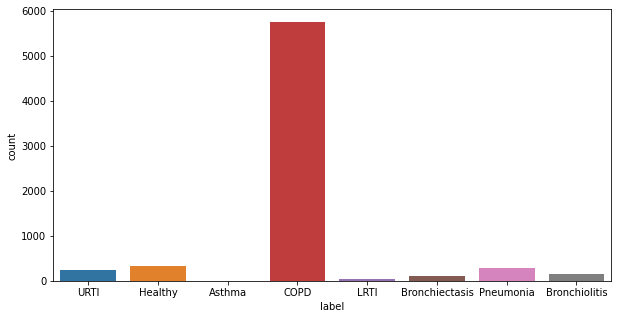

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(files_df['label'])
print(files_df.label.value_counts())

In [ ]:
# We need to check the length per slice :
files_df['len_per_slice'] = files_df['end'].sub(files_df['start'], axis = 0) 
max_len_per_slice = max(files_df['len_per_slice'])
print("Max Breathing length in seconds : ",max_len_per_slice)

Max Breathing length in seconds :  16.163


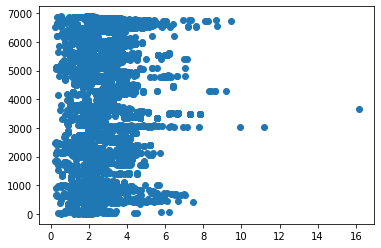

In [ ]:
# since 16.163 is not possible we need to check for the outliers 
plt.scatter(files_df['len_per_slice'], y=files_df.index)


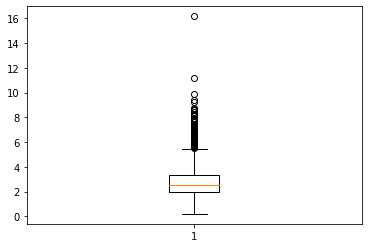

In [ ]:
box = plt.boxplot(files_df['len_per_slice'])

In [ ]:
from matplotlib.cbook import boxplot_stats
force_max_len = math.ceil(boxplot_stats(files_df['len_per_slice'])[0]['whishi'])
force_max_len

6

In [ ]:
def compute_len(samp_rate=22050, time=force_max_len, acquisition_mode=0):
    '''Computes the supposed length of sliced data
        samp_size = sample size from the data
        samp_rate = sampling rate. by default since we're working on 24-bit files, we'll use 96kHz
        time = length of time for the audio file. by default we'll use the max we have which is 5.48
        acquisition_mode = either mono or stereo. 0 for mono, 1 for stereo
    '''
    comp_len = 0
    if acquisition_mode == 1: #ac mode is single channel which means it's 'mono'
        comp_len = samp_rate * time
    else: #stereo
        comp_len = (samp_rate * time) * 2

    return comp_len

In [ ]:
# Extract only COPD and Healthy data from Df 
dataframe = files_df.loc[(files_df['label']=='COPD') | (files_df['label']=='Healthy')]
dataframe.head()

,start,end,crackles,wheezes,filename,pId,ac_mode,label,len_per_slice
23,0.264,1.736,0,0,102_1b1_Ar_sc_Meditron,102.0,sc,Healthy,1.472
24,1.736,3.293,0,0,102_1b1_Ar_sc_Meditron,102.0,sc,Healthy,1.557
25,3.293,5.307,0,0,102_1b1_Ar_sc_Meditron,102.0,sc,Healthy,2.014
26,5.307,6.636,0,0,102_1b1_Ar_sc_Meditron,102.0,sc,Healthy,1.329
27,6.636,8.036,0,0,102_1b1_Ar_sc_Meditron,102.0,sc,Healthy,1.400


In [ ]:
dataframe['label'].value_counts()

COPD       5746
Healthy     322
Name: label, dtype: int64

In [ ]:
!mkdir -p /content/output/COPD
!mkdir -p /content/output/Healthy

! rm -rf 
out_path = '/content/output'

In [ ]:
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
i = 0 #iterator for file naming

for idx, row in dataframe.iterrows():
    filename = row['filename']
    start = row['start']
    end = row['end']
    diag = row['label']
    
    #check len and force to 6 sec if more than that
    if force_max_len < end - start:
        end = start + force_max_len
    
    aud_loc = os.path.join(AUDIO_PATH ,filename + '.wav')
    out_file = os.path.join(out_path,diag+'/'+filename+'_'+str(i)+'.wav')

    data, samplingrate = librosa.load(aud_loc)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
    #pad audio if < forced_max_len
    a_len = compute_len(samp_rate=samplingrate, acquisition_mode=row['ac_mode']=='sc')
    padded_data = librosa.util.pad_center(sliced_data, a_len)

    sf.write(file=out_file, data=padded_data, samplerate=samplingrate)
print("processd files count =",i)

In [ ]:
gc.collect()
"""
This task involves splitting without distorting the folder structure. 
I'm using split_folders python package to do this. 
Source: https://pypi.org/project/split-folders/
"""
! mkdir -p /content/Data
!pip install split_folders


In [ ]:
audio_loc = '/content/output'
split_folders.ratio(audio_loc, output='/content/Data', seed=1337, ratio=(0.8, 0.2))
# ! zip -r COPD_data.zip /content/Data
# #!unzip '/content/drive/My Drive/Medical-Colabbooks/output.zip'

In [ ]:
# ! pip install soundfile
# ! pip install split-folders
# ! pip install tqdm 

# Make Folders 
# os.makedirs('Data')
# os.makedirs('Data/train')
# os.makedirs('Data/val')

In [ ]:
import splitfolders
import numpy as np
import librosa as lb
from librosa.display import specshow
import matplotlib.pyplot as plt
import os
import gc
import librosa.display
import librosa
import pandas as pd

# Audio_loc = '/content/output'
# splitfolders.ratio(Audio_loc, output='/content/Data', seed=1337, ratio=(0.8, 0.2))

train_path = '/content/Data/train'
val_path = '/content/Data/val'

In [ ]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  
  stft = np.abs(librosa.stft(sound))  

  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points(path):
  labels = []
  images = []
  for root,subs,files in os.walk(path):
    for f  in files:
      labels.extend(os.path.split(root)[1])
      file_name = os.path.join(root,f)
      #images.append(audio_features(filename=file_name))


  return labels,images

filelabls , wav_path = data_points(train_path)
gc.collect()

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
# Hot one encode the labels
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import os
import numpy as np
import pandas as pd
# 
artifacts_path = '/content/drive/My Drive/Medical-Colabbooks/sound_artifacts'

In [ ]:
wav_data = np.asarray(joblib.load(os.path.join(artifacts_path,'Wav_features.pkl')))
print(wav_data.shape)
label_data = np.asarray(joblib.load(os.path.join(artifacts_path,'Wav_labels.pkl')))
print(label_data.shape)

(6068, 193)
(6068,)


In [ ]:
label_encoder = preprocessing.LabelEncoder()

labels = label_encoder.fit_transform(label_data)
print(labels)

Class_names = label_encoder.classes_
print(Class_names)

[0 0 0 ... 1 1 1]
['COPD' 'Healthy']


In [ ]:
 # Split data
X_train, X_test, y_train, y_test = train_test_split(wav_data, labels, test_size=0.30, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4247, 193)
(1821, 193)
(4247,)
(1821,)


In [ ]:
#! pip install tpot
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=3,verbosity=2,cv=3,random_state=42)
tpot.fit(X_train,y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(input_matrix, C=25.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.1)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=<ipykernel.iostream.OutStream object at 0x7f37bd23bd68>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=42, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_curve,roc_auc_score,auc
print(tpot.score(X_test, y_test))
results = tpot.predict(X_test)

rfc_pred = pd.DataFrame({'Target_status':y_test,'inference':results})
# Let's check the report of our default model
print ("ROC-AUC Score= {:2.2}".format(roc_auc_score(rfc_pred.Target_status, rfc_pred.inference)))
print ("Accuracy score= {:2.2}".format(accuracy_score(rfc_pred.Target_status, rfc_pred.inference)))
confusion = confusion_matrix(rfc_pred.Target_status,rfc_pred.inference)
print ("Confusion Matrix \n{}".format(confusion))
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN)
print ("Recall= {}".format(TP/float(TP+FN)))
print ("Precison= {}".format(TP/float(TP+FP)))
print ("specificity= {}".format(TN / float(TN+FP)))


0.9890170236133993
ROC-AUC Score= 0.91
Accuracy score= 0.99
Confusion Matrix 
[[1731    6]
 [  14   70]]
TP 70
TN 1731
FP 6
FN 14
Recall= 0.8333333333333334
Precison= 0.9210526315789473
specificity= 0.9965457685664939


# Using Covolution Neural Network 

In [ ]:
X_train  = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.9439604426654109
0.056039557334589124
[0.52968321 8.92226891]


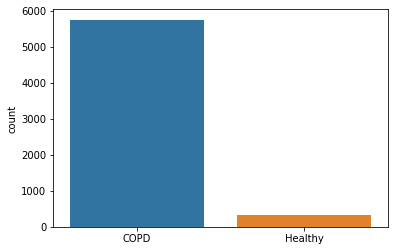

In [ ]:
import seaborn as sns
from sklearn.utils import class_weight
sns.countplot(label_data)
neg, pos = np.bincount(y_train)
total = neg+pos

neg_freq = neg/(neg+pos)
pos_freq = pos/(neg+pos)
print(neg_freq)
print(pos_freq)


classweights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(classweights)
classweight = {0: classweights[0], 1: classweights[1]}


In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Conv1D(256, kernel_size=5, activation='relu'))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1,callbacks=callbacks_list,class_weight=classweight)

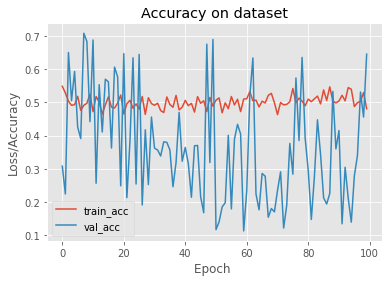

In [ ]:
# plot the training loss and accuracy
N = len(history.history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
from keras.models import load_model
saved_model = load_model('/content/model_weights.h5')

predicted_vals = model.predict(X_test)
y_pred  = [np.argmax(proab) for proab in predicted_vals]
print(y_pred)


[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import itertools
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78      1737
           1       0.03      0.25      0.06        84

    accuracy                           0.65      1821
   macro avg       0.49      0.46      0.42      1821
weighted avg       0.91      0.65      0.75      1821



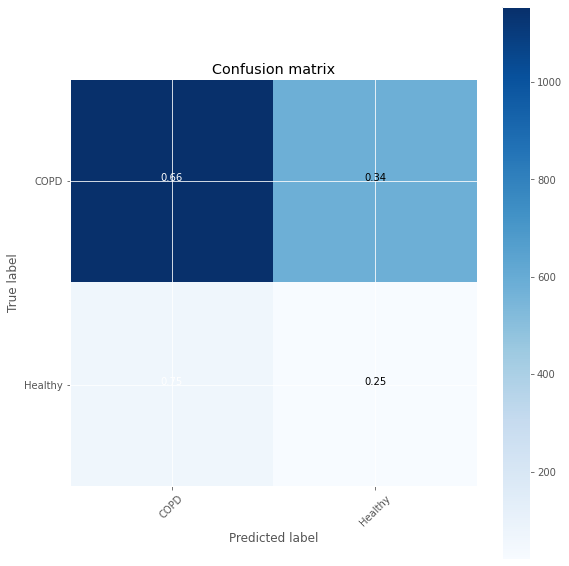

In [ ]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

cnf_matrix = confusion_matrix(y_test,y_pred)
fig = plot_confusion_matrix(cnf_matrix,class_names=Class_names)

In [ ]:
TP = cnf_matrix[1,1]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN)
print ("Recall= {}".format(TP/float(TP+FN)))
print ("Precison= {}".format(TP/float(TP+FP)))
print ("specificity= {}".format(TN / float(TN+FP)))

TP 21
TN 1154
FP 583
FN 63
Recall= 0.25
Precison= 0.0347682119205298
specificity= 0.6643638457109959


## YAMNET Google AUDIO- Classifier 

In [ ]:
# !git clone https://github.com/tensorflow/models.git
# !ls models/research/audioset
# !curl -o yamnet.h5 https://storage.googleapis.com/audioset/yamnet.h5
# ! cp -r /content/models/research/audioset/yamnet/* ./ 
# ! pip install resampy 
# ! pip install pysoundfile
# ! unzip '/content/drive/My Drive/Medical-Colabbooks/sound_artifacts/spectographs_images.zip'


# Building Inception model from YAMNET Spectograph images 

In [23]:
# Imports.
import os
import numpy as np
import pandas as pd
import random
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
# Hot one encode the labels
from sklearn import preprocessing

import gc
# TODO: include my slightly modified yamnet code in this file 
# i added the 'dense_net' return
Data_path  = '/content/spectographs_images'

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Conv2D,Flatten,AveragePooling2D,Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

Train_path = os.path.join(Data_path,'train')
Val_path = os.path.join(Data_path,'val')

train_imgs = []
train_label = []


val_imgs = []
val_label =[]

for raw,subdirs,files in os.walk(Train_path):
  for name in files:
    train_imgs.append(os.path.join(raw, name))
    train_label.append(os.path.split(raw)[1])

for raw,subdirs,files in os.walk(Val_path):
  for name in files:
    val_imgs.append(os.path.join(raw, name))
    val_label.append(os.path.split(raw)[1])


train_df = pd.DataFrame({'images':train_imgs,'labels':train_label})
val_df = pd.DataFrame({'images':val_imgs,'labels':val_label})

print("NUmber of train images: ", len(train_df))
print("NUmber of validation images: ", len(val_df))

gc.collect()

NUmber of train images:  4853
NUmber of validation images:  1215


0

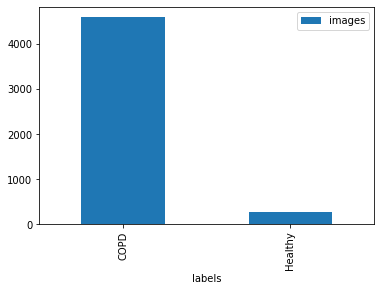

In [4]:
from sklearn.utils import shuffle
train_df = shuffle(train_df,random_state=np.random.seed(47))
train_df.groupby(['labels']).count().plot.bar()

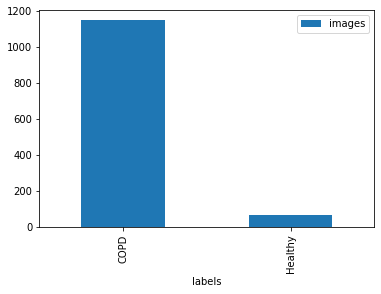

In [5]:
val_df.groupby(['labels']).count().plot.bar()

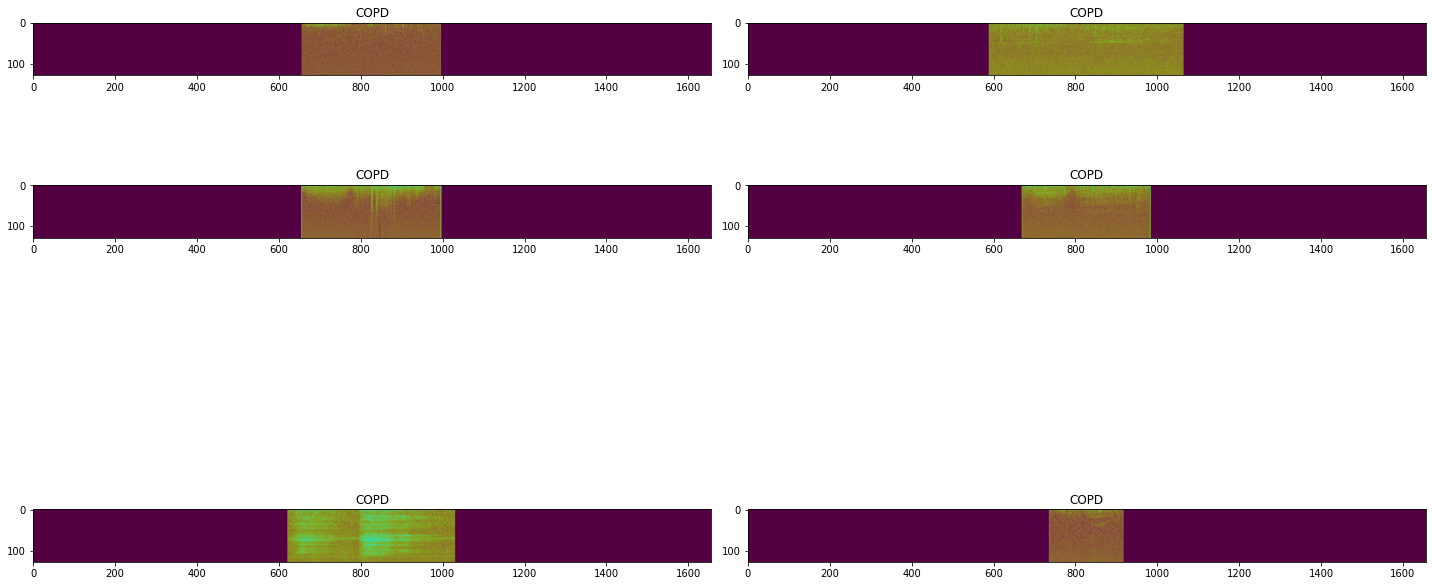

In [6]:
import PIL
import cv2
# Adjust the size of your images
plt.figure(figsize=(20,10))
count = 0
for iterator, row in (train_df.iterrows()):
  filename = row.images
  image = cv2.imread(filename)
  count +=1
  if count>8:break 
  plt.subplot(4,2,count)
  plt.title(row.labels)
  plt.imshow(image, cmap=plt.cm.bone)
  plt.tight_layout()

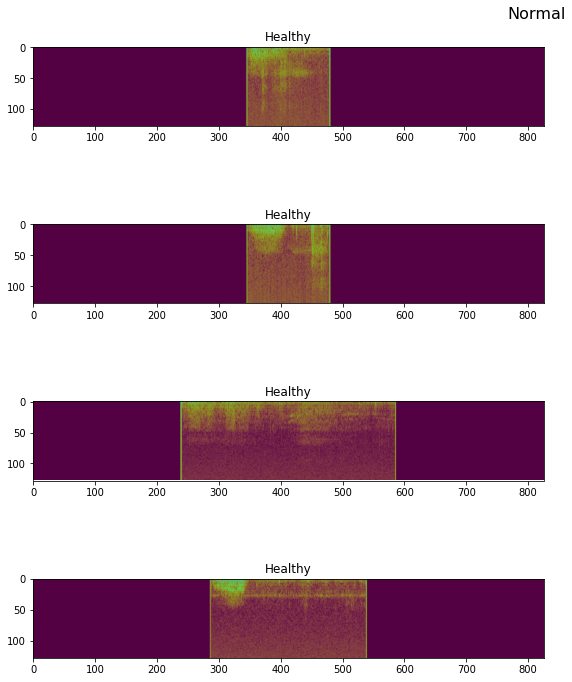

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

count = 0 
for iterator, row in (train_df.iterrows()):
    if row.labels == 'Healthy':
      filename = row.images
      image = cv2.imread(filename)
      count +=1
      if count>8:break 
      plt.subplot(4,2,count)
      plt.title(row.labels)
      plt.imshow(image, cmap=plt.cm.bone)
      plt.tight_layout()
      count +=1
fig.suptitle('Normal', size=16)
plt.show()

In [8]:
def get_train_generator(Train_dir,val_dir,target_w = 128, target_h = 128):      
    
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
                                        samplewise_center=True,
                                        validation_split=0.30,
                                        fill_mode='nearest',
                                        samplewise_std_normalization= True)
    
    train_generator = image_generator.flow_from_directory(Train_dir,
                                                  shuffle=True,                                                  
                                                  class_mode='binary',
                                              target_size=(target_w, target_h))


    validation_datagen = ImageDataGenerator(
        samplewise_center=True,
        validation_split=0.30,
        samplewise_std_normalization= True)
    validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                    class_mode='binary',
                                                    shuffle=True,
                                              target_size=(target_w, target_h))
    
    return train_generator ,validation_generator

train_generator,valid_generator = get_train_generator(Train_path,Val_path, target_w = IMAGE_WIDTH, target_h = IMAGE_HEIGHT)

print(train_generator.class_indices)

getting train generator...
Found 4853 images belonging to 2 classes.
Found 1215 images belonging to 2 classes.
{'COPD': 0, 'Healthy': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 5.2407 and the minimum is -1.6814
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


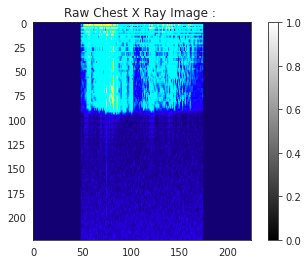

In [9]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
image = generated_image[0].reshape(IMAGE_WIDTH,IMAGE_HEIGHT,3)

plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image : ')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [10]:
from sklearn.utils import class_weight
classweights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.labels),
                                                 train_generator.labels)
print(classweights)


classweight = {0: classweights[0], 1: classweights[1]}

print('Weight for class 0: {:.2f}'.format(classweights[0]))
print('Weight for class 1: {:.2f}'.format(classweights[1]))

[0.52795909 9.44163424]
Weight for class 0: 0.53
Weight for class 1: 9.44


In [ ]:
import matplotlib.pyplot as plt 

print(tf.__version__)
# create the base pre-trained model
base_model = InceptionV3(include_top=False,weights='imagenet',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
head_Model = base_model.output
head_Model = GlobalAveragePooling2D()(head_Model)
head_Model = Flatten(name="flatten")(head_Model)
head_Model = Dense(64, activation="relu")(head_Model)
head_Model = Dropout(0.5)(head_Model)
prediction = Dense(2, activation="softmax")(head_Model)

for layer in base_model.layers[:100]:
    layer.trainable = False


#Compose the final model
model = Model(inputs=base_model.input, outputs=prediction)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
gc.collect()
model.summary()

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

Model_name = 'Inception_V3'+'_pretrained_model.h5'
checkpoint = ModelCheckpoint(Model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping,checkpoint],
    # The class weights go here
    class_weight=classweight
    ) 

Epoch 1/10
152/152 [==============================] - 43s 237ms/step - loss: 0.5954 - accuracy: 0.7210 - val_loss: 3.1923 - val_accuracy: 0.5481

Epoch 00001: val_accuracy improved from -inf to 0.54815, saving model to Inception_V3_pretrained_model.h5
Epoch 2/10
152/152 [==============================] - 34s 222ms/step - loss: 0.4879 - accuracy: 0.8711 - val_loss: 1.5889 - val_accuracy: 0.6247

Epoch 00002: val_accuracy improved from 0.54815 to 0.62469, saving model to Inception_V3_pretrained_model.h5
Epoch 3/10
152/152 [==============================] - 34s 224ms/step - loss: 0.2698 - accuracy: 0.9053 - val_loss: 1.3241 - val_accuracy: 0.7004

Epoch 00003: val_accuracy improved from 0.62469 to 0.70041, saving model to Inception_V3_pretrained_model.h5
Epoch 4/10
152/152 [==============================] - 34s 224ms/step - loss: 0.2178 - accuracy: 0.9217 - val_loss: 2.6283 - val_accuracy: 0.8996

Epoch 00004: val_accuracy improved from 0.70041 to 0.89959, saving model to Inception_V3_pre

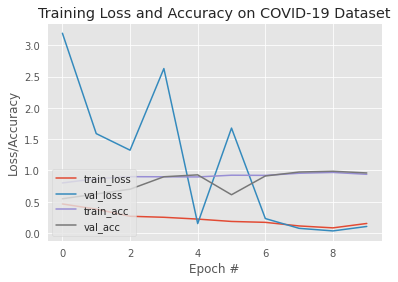

In [14]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

# plot the training loss and accuracy
N = len(history.history['accuracy'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [15]:
best_model=  keras.models.load_model('/content/Inception_V3_pretrained_model.h5')
predicted_vals = best_model.predict_generator(valid_generator, steps = len(valid_generator))

y_pred  = [np.argmax(proab) for proab in predicted_vals]
y_test = valid_generator.labels

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [27]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import itertools
print(classification_report(y_test, y_pred))
print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1150
           1       0.03      0.03      0.03        65

    accuracy                           0.89      1215
   macro avg       0.49      0.49      0.49      1215
weighted avg       0.90      0.89      0.89      1215

Accuracy = 89.38%


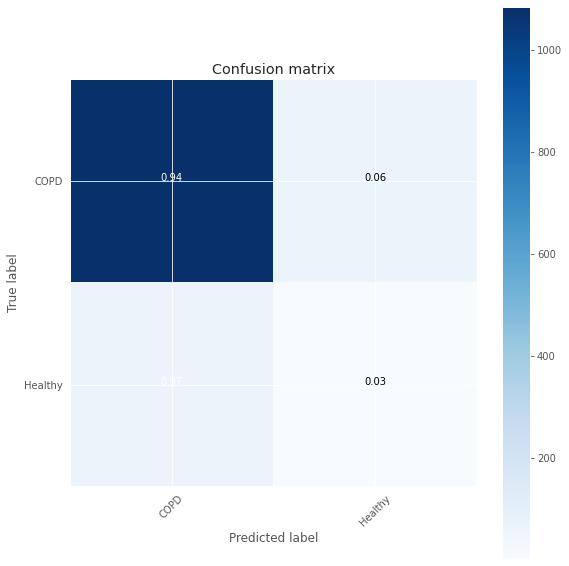

In [17]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

cnf_matrix = confusion_matrix(y_test,y_pred)
fig = plot_confusion_matrix(cnf_matrix,class_names=['COPD','Healthy'])

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
Senstivity  = tp/(tp+fn)
Specificity = tn/(tn+fp)

print("Senstivity = ",Senstivity)
print ("Specificity = ",Specificity)

Senstivity =  0.03076923076923077
Specificity =  0.9426086956521739


In [19]:
import random
from google.colab.patches import cv2_imshow 
from tensorflow.keras.preprocessing import image
class_names=['COPD','Healthy']

ORIGINAL = val_imgs[random.randint(0,len(val_imgs)-1)]
original = cv2.imread(ORIGINAL)
orig = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
print("Image: ",ORIGINAL)
print("Shape of image :",original.shape)
print(orig.shape)


img = image.load_img(ORIGINAL, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

# Preict with the model 
idx = np.argmax(model.predict(x))
print(model.predict(x))
print("Predicted label ",class_names[idx])

Image:  /content/spectographs_images/val/COPD/107_2b5_Ll_mc_AKGC417L_214.png
Shape of image : (128, 1656, 3)
(128, 1656, 3)
(1, 224, 224, 3)
[[0.98387754 0.01612243]]
Predicted label  COPD


In [20]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # resize the heatmap to oringnal X-Ray image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

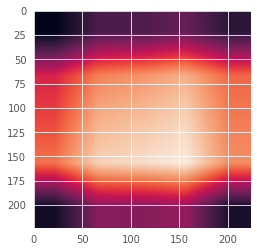

In [21]:
cam = GradCAM(model=model, classIdx=idx, layerName='mixed9_1') # find the last 4d shape "mixed10" in this case
heatmap = cam.compute_heatmap(x)
#show the calculated heatmap
plt.imshow(heatmap)
plt.show()

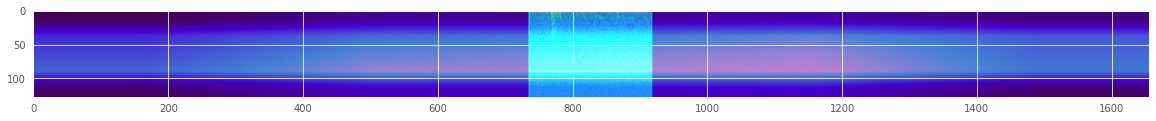

In [22]:
# Old fashioned way to overlay a transparent heatmap onto original image, the same as above
INTENSITY = 0.5
heatmapY = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmapY = cv2.applyColorMap(heatmapY, cv2.COLORMAP_HOT) 
imageY = cv2.addWeighted(heatmapY, 0.5, orig, 1.0, 0)
plt.figure(figsize=(20,20))
plt.imshow(imageY)